In [ ]:
# Create the Kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Copy the Kaggle API token (kaggle.json) to the Kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the correct permissions for the kaggle.json file (read/write only for the user)
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Download the "car-plate-detection" dataset from Kaggle
!kaggle datasets download andrewmvd/car-plate-detection


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0


In [ ]:
# Unzip the downloaded dataset
!unzip -q car-plate-detection.zip


Archive:  car-plate-detection.zip
  inflating: annotations/Cars0.xml   
  inflating: annotations/Cars1.xml   
  inflating: annotations/Cars10.xml  
  inflating: annotations/Cars100.xml  
  inflating: annotations/Cars101.xml  
  inflating: annotations/Cars102.xml  
  inflating: annotations/Cars103.xml  
  inflating: annotations/Cars104.xml  
  inflating: annotations/Cars105.xml  
  inflating: annotations/Cars106.xml  
  inflating: annotations/Cars107.xml  
  inflating: annotations/Cars108.xml  
  inflating: annotations/Cars109.xml  
  inflating: annotations/Cars11.xml  
  inflating: annotations/Cars110.xml  
  inflating: annotations/Cars111.xml  
  inflating: annotations/Cars112.xml  
  inflating: annotations/Cars113.xml  
  inflating: annotations/Cars114.xml  
  inflating: annotations/Cars115.xml  
  inflating: annotations/Cars116.xml  
  inflating: annotations/Cars117.xml  
  inflating: annotations/Cars118.xml  
  inflating: annotations/Cars119.xml  
  inflating: annotations/Cars12.xm

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Set paths for annotations, images, and output labels
annotations_path = '/content/car-plate-detection/annotations'
images_path = '/content/car-plate-detection/images'
labels_path = '/content/car-plate-detection/labels'

# Create the labels directory if it doesn't exist
os.makedirs(labels_path, exist_ok=True)

# Function to convert a single VOC annotation to YOLO format
def convert_annotation(xml_file, image_size):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    w, h = image_size

    yolo_annotations = []
    for obj in root.iter('object'):
        cls = 0  # Assuming only one class: 'plate'
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        ymin = int(xmlbox.find('ymin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymax = int(xmlbox.find('ymax').text)

        # Convert to YOLO format (normalized center_x, center_y, width, height)
        x_center = ((xmin + xmax) / 2) / w
        y_center = ((ymin + ymax) / 2) / h
        bbox_width = (xmax - xmin) / w
        bbox_height = (ymax - ymin) / h

        yolo_annotations.append(f"{cls} {x_center} {y_center} {bbox_width} {bbox_height}")
    return yolo_annotations

# Process all annotation XML files
for xml_file in os.listdir(annotations_path):
    if not xml_file.endswith('.xml'):
        continue  # Skip non-XML files

    xml_path = os.path.join(annotations_path, xml_file)
    img_filename = xml_file.replace('.xml', '.png')
    img_path = os.path.join(images_path, img_filename)

    if not os.path.exists(img_path):
        continue  # Skip if corresponding image doesn't exist

    image = Image.open(img_path)
    image_size = image.size  # (width, height)

    # Convert VOC annotation to YOLO format
    yolo_labels = convert_annotation(xml_path, image_size)

    # Save the YOLO annotation to a .txt file
    label_file = os.path.join(labels_path, xml_file.replace('.xml', '.txt'))
    with open(label_file, 'w') as f:
        f.write('\n'.join(yolo_labels))


In [ ]:
# Install the Ultralytics library (includes YOLOv8 and more)
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os

# Function to generate a classes.txt file based on YOLO label files
def generate_classes_txt(labels_folder, output_classes_txt):
    classes_set = set()

    # Iterate over all label files in the folder
    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_folder, label_file), 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.split()[0])  # The first value in each line is the class ID
                        classes_set.add(class_id)

    # If no classes were found, exit
    if not classes_set:
        print('No classes found in label files!')
        return

    # Sort class IDs to ensure they are in correct order
    classes_list = sorted(list(classes_set))

    # Create a classes.txt file with dummy class names (e.g., class_0, class_1, etc.)
    with open(output_classes_txt, 'w') as f:
        for class_id in classes_list:
            f.write(f'class_{class_id}\n')

    print(f'classes.txt created at {output_classes_txt} with {len(classes_list)} classes.')


labels_folder = '/content/car-plate-detection/labels'  # Folder containing YOLO .txt label files
output_classes_txt = '/content/car-plate-detection/classes.txt'

generate_classes_txt(labels_folder, output_classes_txt)


classes.txt created at /content/car-plate-detection/classes.txt with 1 classes.


In [ ]:
import os
import random
import shutil

# Function to split dataset into training and validation sets
def split_dataset(images_dir, labels_dir, output_dir, train_ratio=0.8):
    # Create output folders for train and val splits
    for split in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

    # Get all image files (filter out non-image files and directories)
    images = [img for img in os.listdir(images_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png')) and os.path.isfile(os.path.join(images_dir, img))]
    random.shuffle(images)  # Shuffle images randomly for better split

    # Calculate split sizes
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    val_images = images[train_size:]

    # Copy images and corresponding labels into the split folders
    for image_set, split in [(train_images, 'train'), (val_images, 'val')]:
        for img_name in image_set:
            label_name = os.path.splitext(img_name)[0] + '.txt'

            # Copy image file
            src_img = os.path.join(images_dir, img_name)
            dst_img = os.path.join(output_dir, 'images', split, img_name)
            shutil.copyfile(src_img, dst_img)

            # Copy corresponding label file if it exists
            src_label = os.path.join(labels_dir, label_name)
            dst_label = os.path.join(output_dir, 'labels', split, label_name)
            if os.path.exists(src_label):
                shutil.copyfile(src_label, dst_label)

    print(f'Dataset split completed. Train: {len(train_images)} images, Val: {len(val_images)} images.')

# Example usage
images_dir = '/content/car-plate-detection/images'
labels_dir = '/content/car-plate-detection/labels'
output_dir = '/content/car-plate-detection'

split_dataset(images_dir, labels_dir, output_dir)


Dataset split completed. Train: 346 images, Val: 87 images.


In [ ]:
import yaml
import os

def create_data_yaml(path_to_data_dir, path_to_classes_txt, path_to_data_yaml):
    # Read classes.txt to get class names
    if not os.path.exists(path_to_classes_txt):
        print(f'classes.txt file not found! Please create a classes.txt file at {path_to_classes_txt}')
        return

    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]
    number_of_classes = len(classes)

    # Create the data dictionary
    data = {
        'path': path_to_data_dir,   # Base path to the dataset folder
        'train': 'images/train',    # Relative path to train images
        'val': 'images/val',        # Relative path to val images
        'nc': number_of_classes,    # Number of classes
        'names': classes            # List of class names
    }

    # Write the dictionary to a YAML file
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)

    print(f'Created config file at {path_to_data_yaml}')

# Define paths
path_to_data_dir = '/content/car-plate-detection'  # Base folder of your dataset
path_to_classes_txt = '/content/car-plate-detection/classes.txt'
path_to_data_yaml = '/content/car-plate-detection/data.yaml'

# Run the function
create_data_yaml(path_to_data_dir, path_to_classes_txt, path_to_data_yaml)

# Display the contents of the created YAML file
print('\nFile contents:\n')
!cat /content/license_plate_data/data.yaml


Created config file at /content/car-plate-detection/data.yaml

File contents:

cat: /content/license_plate_data/data.yaml: No such file or directory


In [ ]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 Nano model
model = YOLO('yolov8n.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 175MB/s]


In [ ]:
model.train(
    data='/content/car-plate-detection/data.yaml',  # Path to the data configuration file (contains paths and number of classes)
    epochs=100,      # Number of training epochs
    batch=16,        # Batch size (number of images per training step)
    device='cuda',   # Use GPU for faster training (use 'cpu' if GPU is not available)
    imgsz=320,       # Image size (input images will be resized to 320x320)
    cache=True       # Cache images in memory for faster training (uses more RAM)
)


Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/car-plate-detection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 41.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 163MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2688.2±1565.8 MB/s, size: 591.8 KB)


train: Scanning /content/car-plate-detection/labels/train... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 901.29it/s]

train: New cache created: /content/car-plate-detection/labels/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 346/346 [00:04<00:00, 73.15it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1906.3±1420.3 MB/s, size: 576.5 KB)


val: Scanning /content/car-plate-detection/labels/val... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 364.77it/s]

val: New cache created: /content/car-plate-detection/labels/val.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 87/87 [00:01<00:00, 78.51it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.602G      1.709      2.881      1.276         23        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         87         95      0.004      0.937      0.343      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.641G      1.578      1.551      1.164         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

                   all         87         95    0.00574      0.863     0.0145    0.00813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.668G      1.615      1.409      1.162         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

                   all         87         95      0.681      0.347      0.506      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.686G      1.607      1.326      1.183         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

                   all         87         95      0.572      0.435      0.433       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.701G      1.536      1.284      1.161         23        320: 100%|██████████| 22/22 [00:03<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.45it/s]

                   all         87         95      0.705      0.663      0.695      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.719G      1.544      1.223      1.155         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         87         95      0.589      0.632      0.579      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.736G      1.476      1.166      1.158         12        320: 100%|██████████| 22/22 [00:02<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

                   all         87         95      0.614      0.663      0.585      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.752G      1.474      1.113      1.168         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]

                   all         87         95      0.723      0.758      0.707      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      0.77G      1.459      1.091       1.15         23        320: 100%|██████████| 22/22 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]

                   all         87         95      0.812      0.653      0.756      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.787G       1.45      1.007      1.141         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

                   all         87         95      0.931      0.705      0.844      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.803G      1.423     0.9877       1.15         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.07it/s]

                   all         87         95      0.862      0.726      0.848      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.82G      1.407     0.9712      1.147         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

                   all         87         95      0.891      0.779      0.825       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.838G      1.392     0.9403      1.131         13        320: 100%|██████████| 22/22 [00:03<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]

                   all         87         95      0.921      0.716       0.81      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.855G      1.424     0.9344      1.106         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         87         95      0.941      0.835      0.884      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.871G      1.351     0.9125      1.101         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.90it/s]

                   all         87         95      0.897        0.8      0.854       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.889G      1.327     0.9162      1.076         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         87         95      0.874        0.8      0.861      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.906G      1.356     0.8763      1.105         16        320: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]

                   all         87         95      0.909      0.737      0.845      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.922G      1.366      0.904       1.11         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

                   all         87         95      0.936      0.765      0.852      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.939G      1.325     0.8555      1.116         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]

                   all         87         95       0.87      0.863      0.905      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.957G      1.297     0.8397      1.073         25        320: 100%|██████████| 22/22 [00:02<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]

                   all         87         95      0.866      0.819      0.863      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.973G      1.268      0.845      1.077         21        320: 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         87         95      0.872      0.863      0.914      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.992G      1.251     0.7892      1.077         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

                   all         87         95       0.91      0.789       0.87      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.01G      1.257     0.7799      1.088         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

                   all         87         95      0.975      0.831      0.907      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.02G      1.252     0.8073      1.074         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         87         95      0.959      0.747      0.864      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.04G      1.268     0.7734      1.067         28        320: 100%|██████████| 22/22 [00:02<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         87         95      0.937      0.832      0.897      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.06G       1.22     0.7495      1.046         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.19it/s]

                   all         87         95      0.898      0.863       0.91      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.08G      1.217     0.7439      1.054         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]

                   all         87         95      0.893      0.874      0.904      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.09G      1.187     0.7504      1.042         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         87         95      0.927      0.821      0.887      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.11G      1.232     0.7655      1.042         23        320: 100%|██████████| 22/22 [00:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         87         95      0.927      0.789      0.846      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.13G      1.179     0.7302      1.041         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         87         95      0.961      0.787      0.866      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.14G       1.17     0.7055      1.026         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         87         95       0.95      0.806      0.889       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.16G      1.206     0.7251      1.035         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         87         95      0.964      0.779      0.878      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.18G      1.142       0.72      1.036         21        320: 100%|██████████| 22/22 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         87         95      0.894      0.842       0.88      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.2G      1.153     0.6935      1.031         25        320: 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]

                   all         87         95      0.911      0.874      0.899      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.21G      1.151     0.6955      1.025         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         87         95      0.928      0.832      0.904      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.23G      1.093      0.697       1.01         29        320: 100%|██████████| 22/22 [00:02<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         87         95      0.909      0.905      0.928      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.25G      1.085     0.6501      1.013         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

                   all         87         95       0.93      0.853      0.917      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.26G      1.146     0.6619      1.022         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

                   all         87         95      0.934      0.842      0.908      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.28G       1.17     0.6876      1.029         16        320: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         87         95      0.907      0.922      0.931      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       1.3G      1.081     0.6572     0.9932         22        320: 100%|██████████| 22/22 [00:02<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         87         95      0.929      0.884      0.915      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.31G       1.09     0.6517      1.011         26        320: 100%|██████████| 22/22 [00:02<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.08it/s]

                   all         87         95       0.95      0.842      0.901      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.33G      1.122     0.6604      1.016         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

                   all         87         95      0.895      0.895      0.925      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.35G      1.099     0.6737     0.9899         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

                   all         87         95      0.951      0.853      0.929      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.37G      1.068     0.6459       1.02         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

                   all         87         95      0.913      0.887      0.916      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.38G      1.034     0.6439      1.006         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]

                   all         87         95      0.928      0.905      0.934      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       1.4G      1.049     0.6208     0.9854         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         87         95      0.942      0.905      0.919      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.42G      1.094     0.6552      1.013         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]

                   all         87         95      0.913      0.882      0.923      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.43G      1.088     0.6376      1.015         19        320: 100%|██████████| 22/22 [00:03<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         87         95      0.892      0.863      0.913       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.45G      1.054     0.6293     0.9933         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

                   all         87         95      0.924      0.892      0.929      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.47G      1.039     0.6178      0.983         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]

                   all         87         95      0.979      0.863      0.935      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.48G      1.022     0.6036      0.968         24        320: 100%|██████████| 22/22 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]

                   all         87         95      0.935      0.884      0.916      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       1.5G      1.021     0.5834     0.9801         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         87         95      0.945      0.896      0.927      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.52G      1.033     0.6137     0.9726         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         87         95      0.933      0.884       0.94      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.54G     0.9835     0.5705     0.9782         14        320: 100%|██████████| 22/22 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         87         95      0.954      0.872      0.939      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.55G     0.9781     0.5646     0.9685         21        320: 100%|██████████| 22/22 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         87         95      0.965      0.842      0.919       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.57G     0.9906     0.5728     0.9743         25        320: 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]

                   all         87         95      0.944      0.895      0.949      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.59G     0.9897     0.5881     0.9743         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

                   all         87         95      0.914      0.926      0.947      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.61G     0.9822     0.5847     0.9811         25        320: 100%|██████████| 22/22 [00:02<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         87         95      0.931      0.849      0.918      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.62G     0.9756     0.5637     0.9585         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         87         95      0.932      0.864      0.922      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.64G     0.9511     0.5533     0.9699         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.95it/s]

                   all         87         95       0.94      0.926      0.941      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.66G     0.9274     0.5584      0.941         27        320: 100%|██████████| 22/22 [00:02<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

                   all         87         95      0.947      0.932      0.951      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.67G     0.9154     0.5629     0.9367         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

                   all         87         95      0.966      0.902      0.946      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.69G      0.913     0.5363     0.9414         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

                   all         87         95       0.96      0.905      0.954      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.71G      0.917     0.5497     0.9499         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         87         95      0.958      0.895      0.953      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.72G     0.9147     0.5421     0.9539         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         87         95      0.941      0.863      0.922       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.74G     0.9466     0.5579     0.9658         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

                   all         87         95      0.925      0.874      0.926       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.76G     0.9207      0.553     0.9588         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         87         95      0.946      0.923      0.951      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.78G     0.8713     0.5258     0.9364         26        320: 100%|██████████| 22/22 [00:03<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.97it/s]

                   all         87         95      0.967      0.925      0.937      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.79G     0.9344     0.5442     0.9491         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         87         95      0.964      0.916      0.951      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.81G     0.8834     0.5273     0.9522         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.35it/s]

                   all         87         95      0.967      0.937      0.957      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.83G     0.8816     0.5139     0.9289         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.87it/s]

                   all         87         95      0.967      0.937      0.961       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.84G     0.9226     0.5274      0.949         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         87         95      0.957       0.93      0.957      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.86G     0.9228     0.5334     0.9425         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         87         95      0.943      0.937      0.954      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.88G     0.8858     0.5146     0.9545         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]

                   all         87         95      0.937      0.936      0.947      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.89G     0.8789     0.5159     0.9461         12        320: 100%|██████████| 22/22 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         87         95      0.936      0.918      0.954      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.91G     0.8749     0.5024     0.9261         18        320: 100%|██████████| 22/22 [00:03<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

                   all         87         95       0.94      0.926      0.949      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.93G     0.8964     0.5264     0.9562         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]

                   all         87         95      0.935      0.913      0.936      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.95G     0.8783     0.5105     0.9445         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         87         95      0.933      0.905      0.931      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.96G     0.8633     0.4994     0.9502         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         87         95      0.932      0.916       0.94       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.98G     0.8439     0.4964     0.9247         20        320: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         87         95      0.955      0.901      0.953       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         2G     0.8328     0.4912     0.9357         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]

                   all         87         95      0.958      0.895      0.934       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.01G     0.8203     0.4868     0.9264         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

                   all         87         95      0.935      0.914      0.934      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.03G     0.8488     0.4862      0.944         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]

                   all         87         95      0.944      0.926      0.948      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.05G       0.88     0.4917     0.9329         23        320: 100%|██████████| 22/22 [00:02<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]

                   all         87         95      0.956      0.919      0.941      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.06G     0.7982     0.4643     0.9107         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

                   all         87         95      0.941      0.916      0.941      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.08G     0.8306     0.4856     0.9259         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]

                   all         87         95      0.945      0.926      0.947      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.1G     0.8085     0.4605     0.9305         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         87         95      0.942      0.916      0.947      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.12G     0.8045      0.469     0.9079         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

                   all         87         95      0.936      0.923      0.959       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.13G      0.824     0.4779     0.9365         20        320: 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         87         95      0.933      0.926      0.959      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.15G     0.7915     0.4585     0.9111         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]

                   all         87         95      0.936      0.924      0.958      0.585


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.16G       1.06     0.5522      1.047         10        320: 100%|██████████| 22/22 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         87         95      0.927      0.931      0.955      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.18G      1.075     0.5282      1.058         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         87         95      0.937      0.947       0.96      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.2G      1.001     0.5355      1.028         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

                   all         87         95      0.936      0.931      0.963       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.22G      1.037     0.5286      1.023         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         87         95      0.966      0.907      0.961      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.23G      1.002     0.5103      1.018         12        320: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.92it/s]

                   all         87         95      0.975      0.905      0.961      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.25G     0.9961     0.4989     0.9908         11        320: 100%|██████████| 22/22 [00:02<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

                   all         87         95       0.95      0.947      0.965      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.27G     0.9658      0.505     0.9831         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

                   all         87         95      0.956      0.947      0.966      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.29G     0.9839      0.512      1.005         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         87         95      0.954      0.947      0.966      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.3G     0.9952     0.5097       1.01         10        320: 100%|██████████| 22/22 [00:03<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         87         95      0.947      0.937      0.963      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.32G     0.9952     0.5179      1.014         10        320: 100%|██████████| 22/22 [00:02<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         87         95      0.947      0.938      0.964      0.582



100 epochs completed in 0.092 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]


                   all         87         95      0.937      0.947       0.96      0.596
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787ee41edd90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
from ultralytics import YOLO

# Load the best trained YOLO model from the specified path
model = YOLO('/content/runs/detect/train/weights/best.pt')


In [ ]:
results = model.predict(
    source='/content/car-plate-detection/images/val',  # Folder containing images for prediction
    save=True,         # Save the predicted images with bounding boxes drawn
    conf=0.5,          # Confidence threshold (only show detections with confidence > 50%)
    device='cuda',     # Use GPU for faster inference (use 'cpu' if no GPU)
)



image 1/87 /content/car-plate-detection/images/val/Cars0.png: 192x320 1 plate, 10.7ms
image 2/87 /content/car-plate-detection/images/val/Cars10.png: 192x320 1 plate, 12.9ms
image 3/87 /content/car-plate-detection/images/val/Cars100.png: 224x320 (no detections), 57.4ms
image 4/87 /content/car-plate-detection/images/val/Cars101.png: 256x320 1 plate, 58.0ms
image 5/87 /content/car-plate-detection/images/val/Cars114.png: 192x320 (no detections), 12.0ms
image 6/87 /content/car-plate-detection/images/val/Cars116.png: 288x320 1 plate, 65.2ms
image 7/87 /content/car-plate-detection/images/val/Cars117.png: 160x320 (no detections), 50.2ms
image 8/87 /content/car-plate-detection/images/val/Cars119.png: 224x320 (no detections), 11.3ms
image 9/87 /content/car-plate-detection/images/val/Cars121.png: 256x320 (no detections), 9.0ms
image 10/87 /content/car-plate-detection/images/val/Cars123.png: 256x320 1 plate, 8.4ms
image 11/87 /content/car-plate-detection/images/val/Cars136.png: 224x320 1 plate, 1

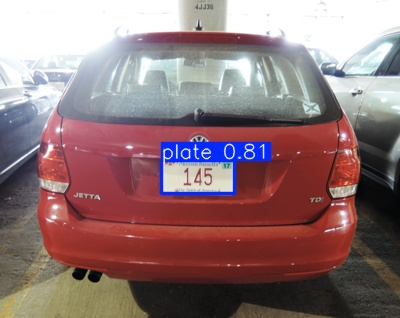

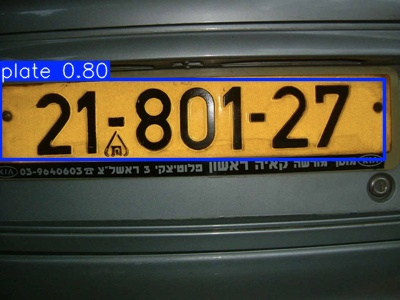

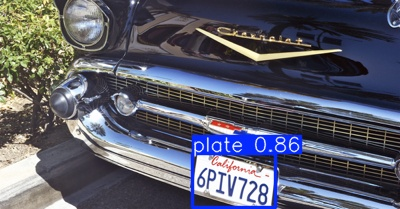

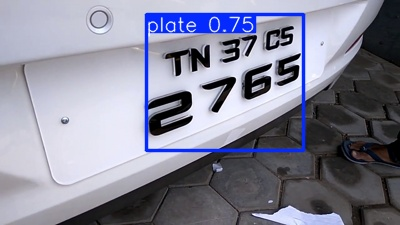

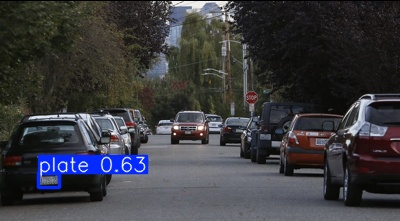

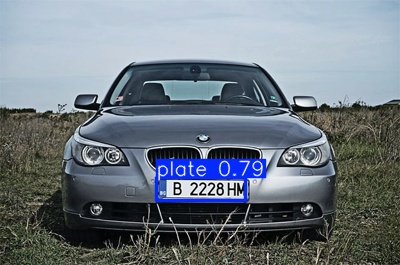

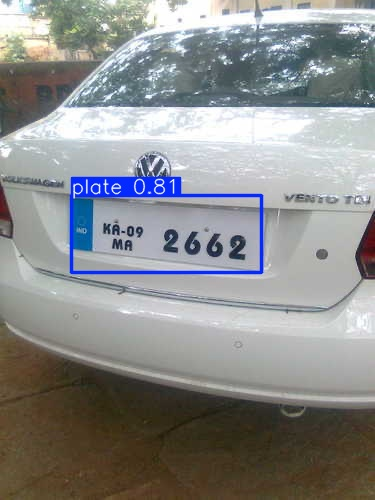

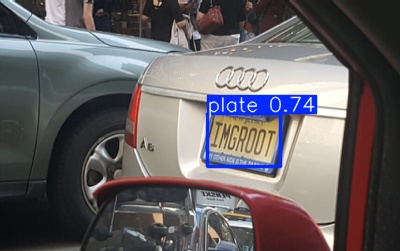

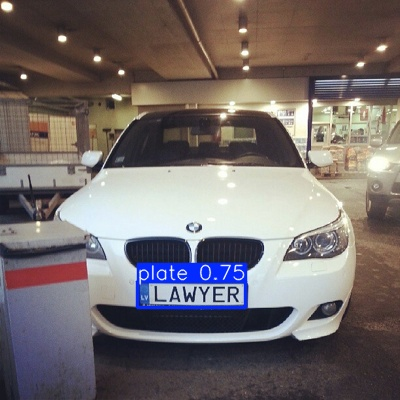

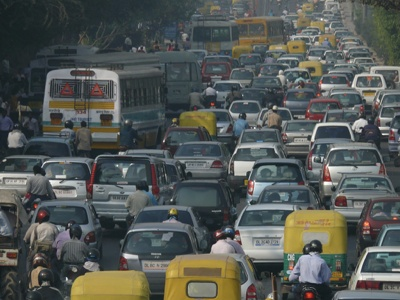

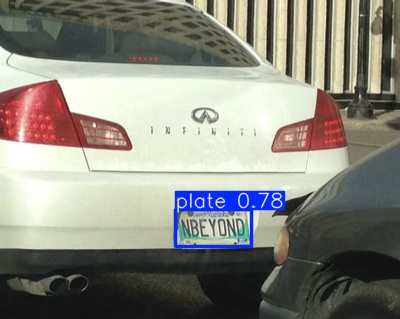

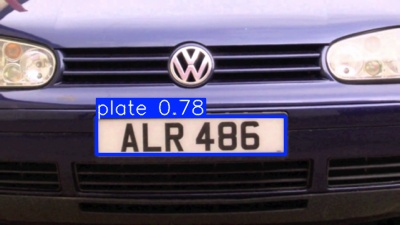

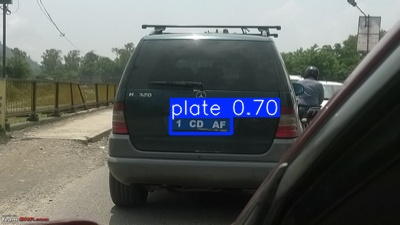

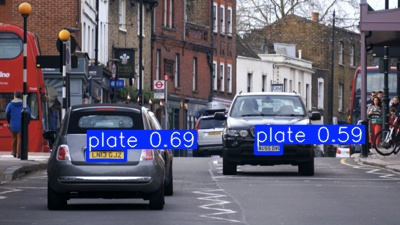

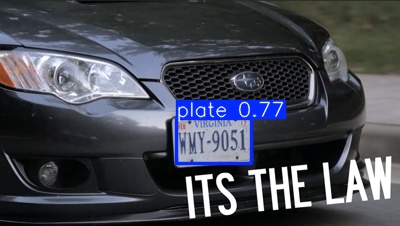

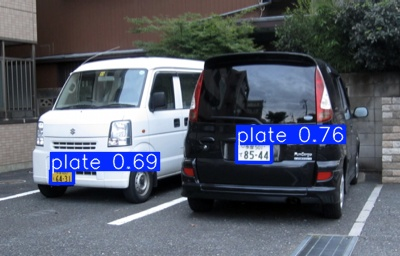

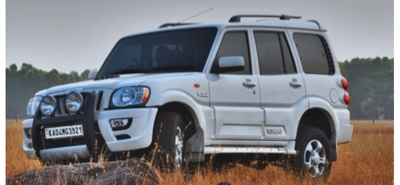

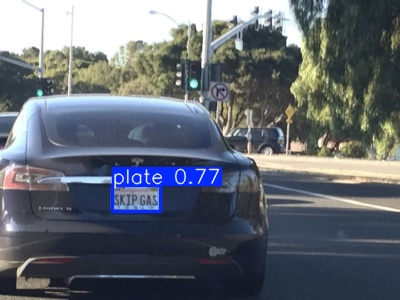

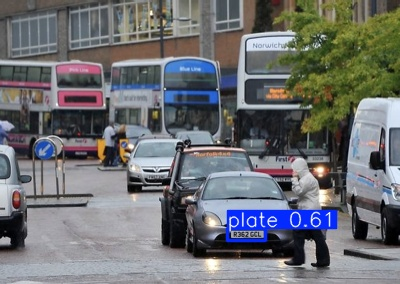

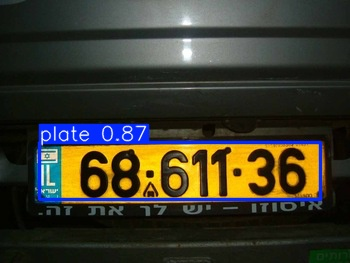

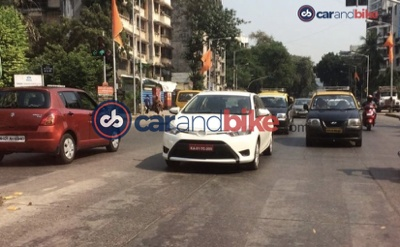

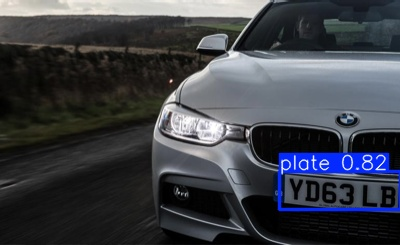

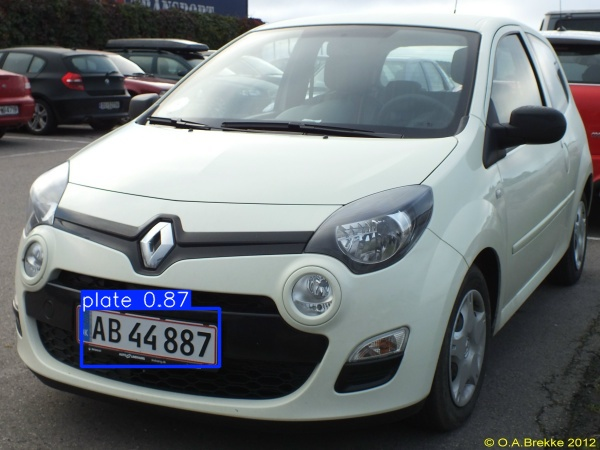

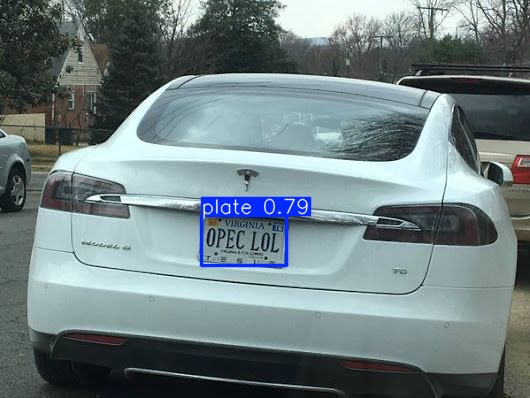

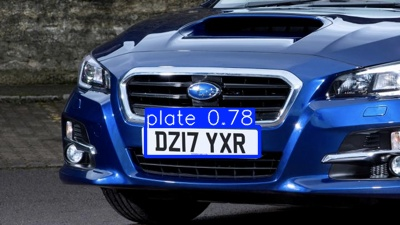

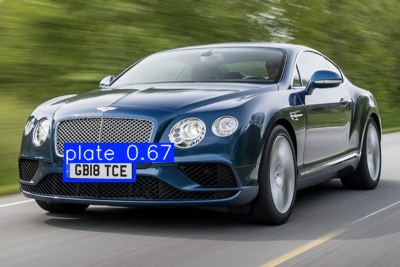

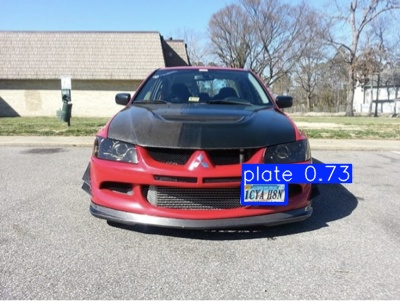

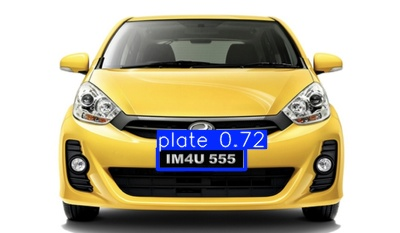

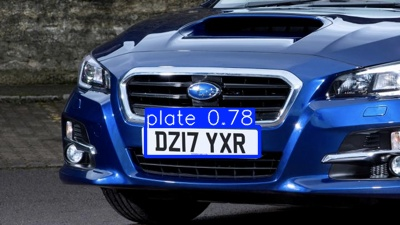

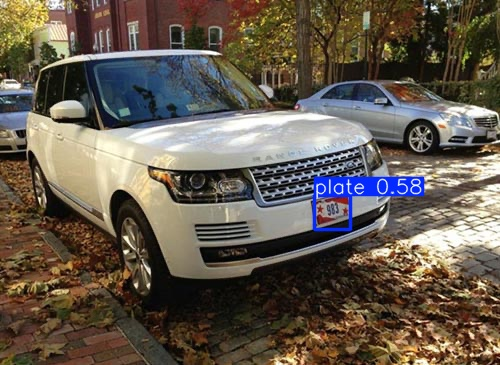

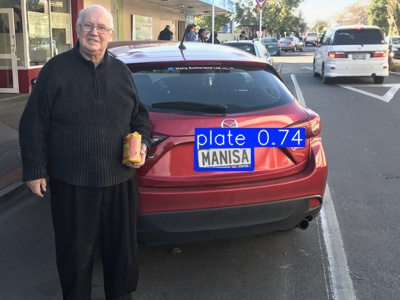

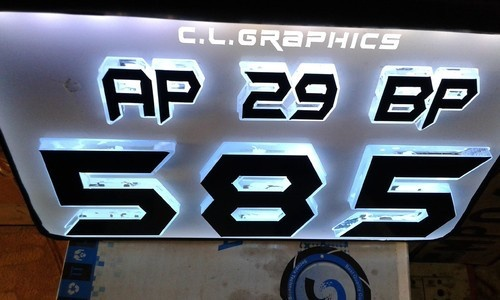

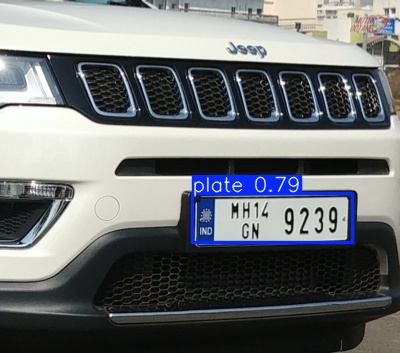

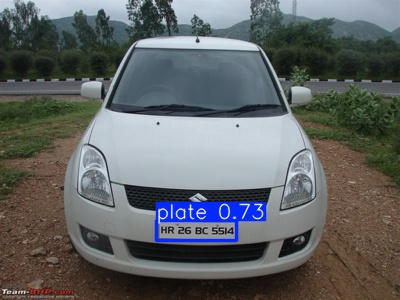

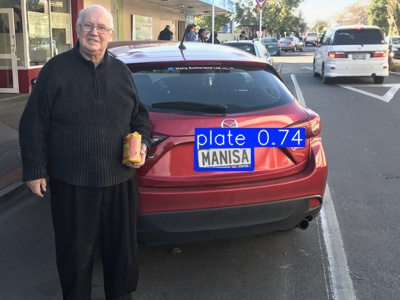

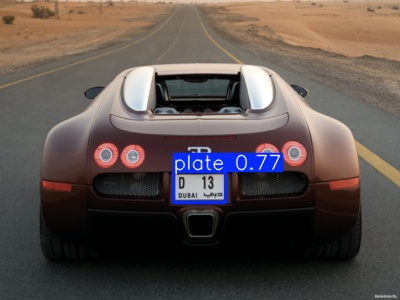

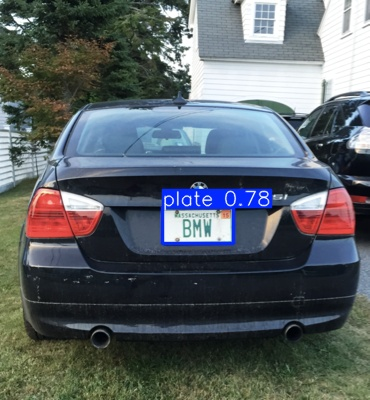

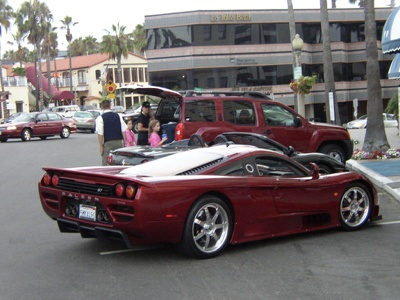

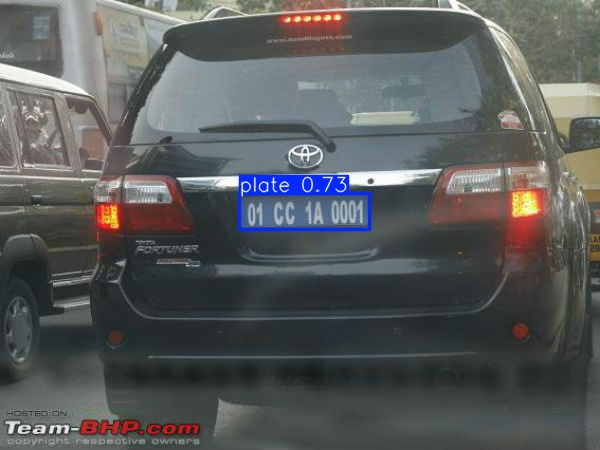

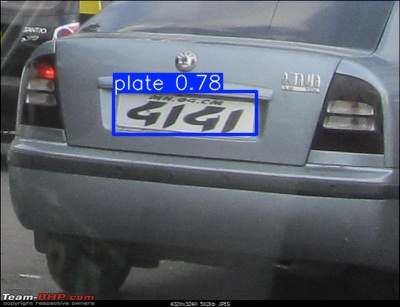

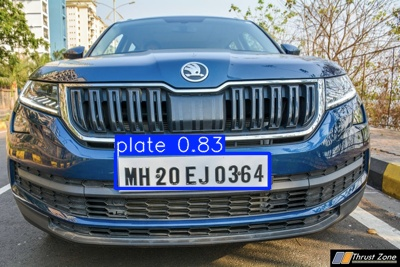

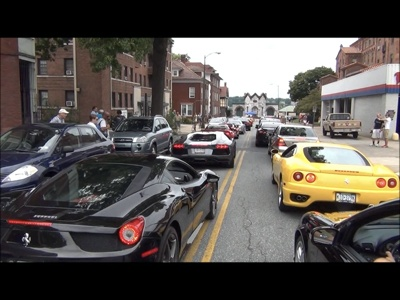

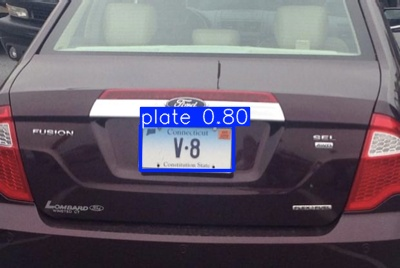

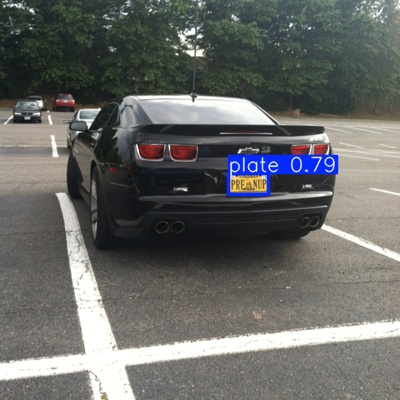

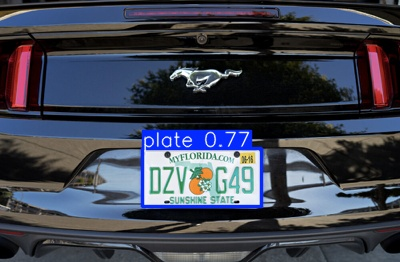

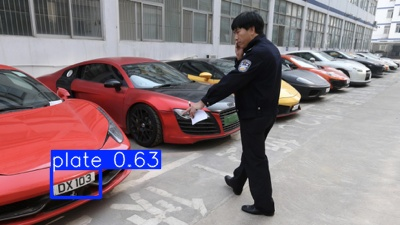

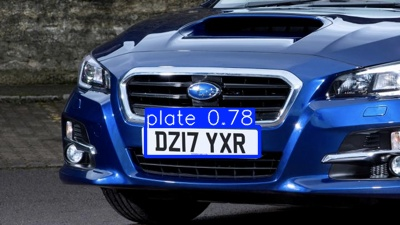

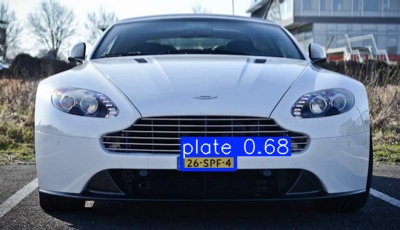

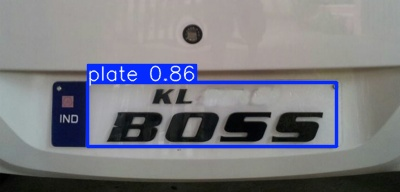

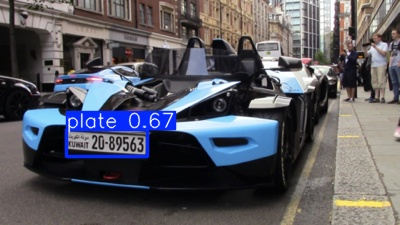

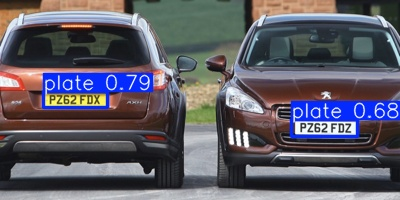

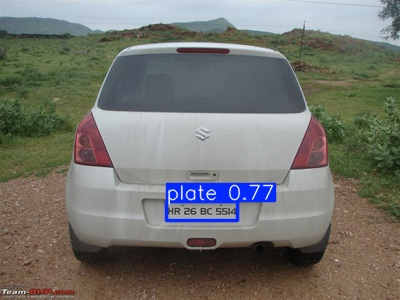

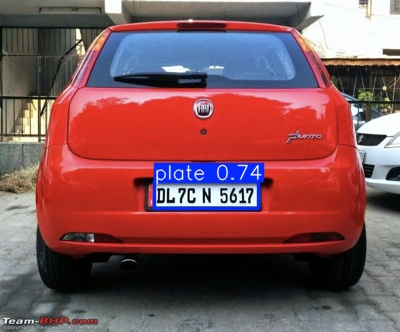

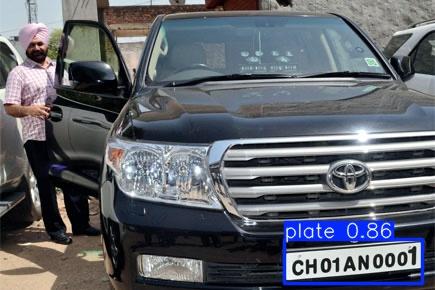

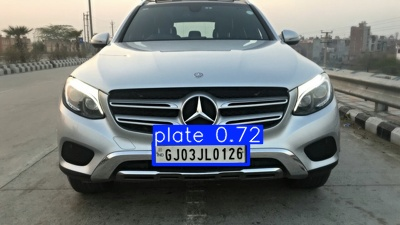

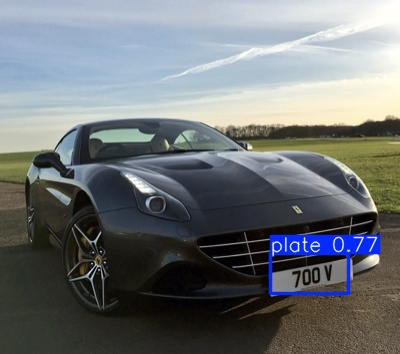

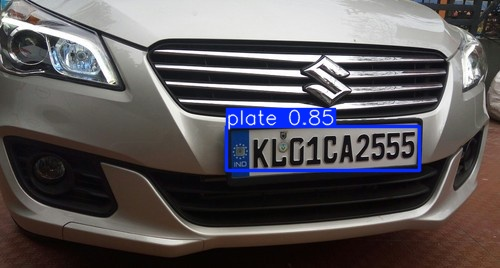

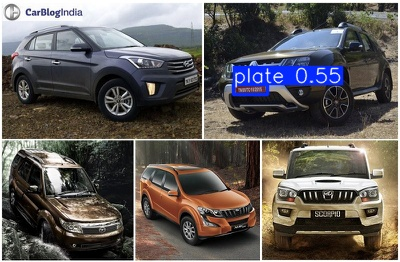

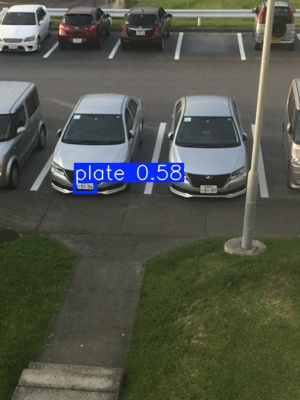

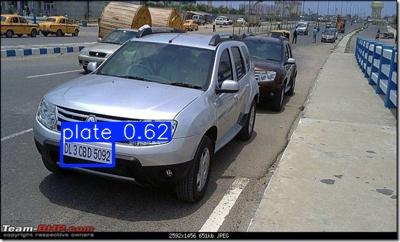

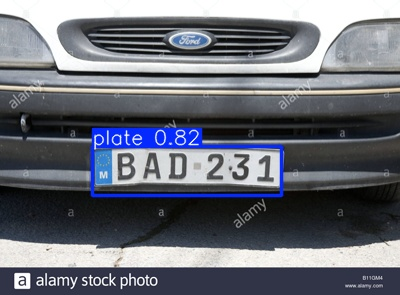

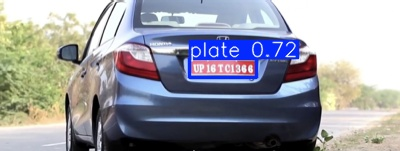

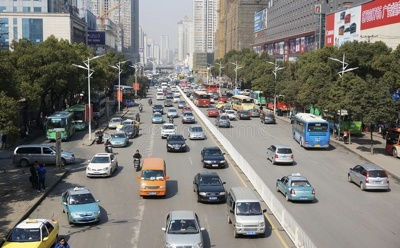

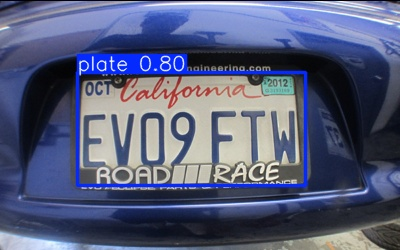

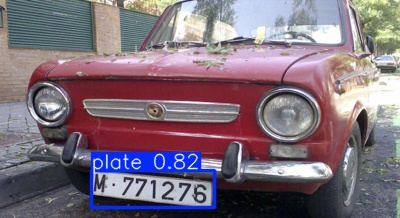

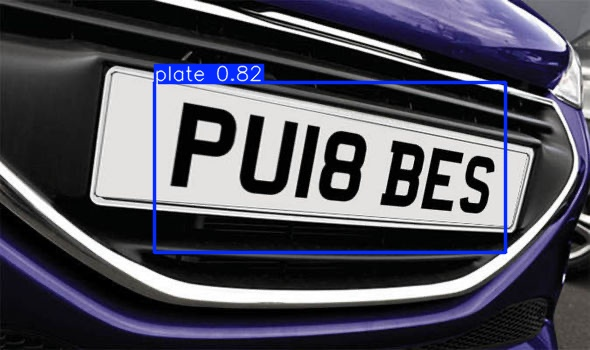

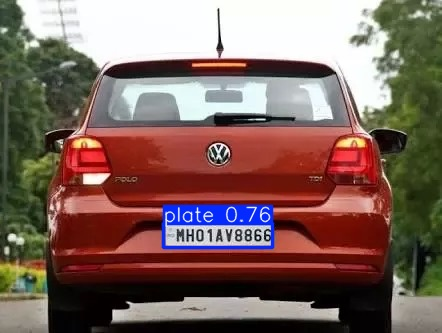

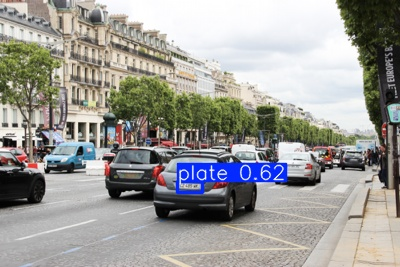

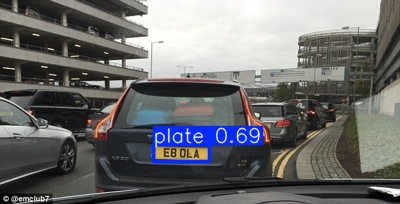

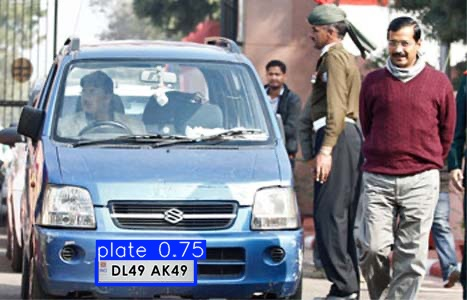

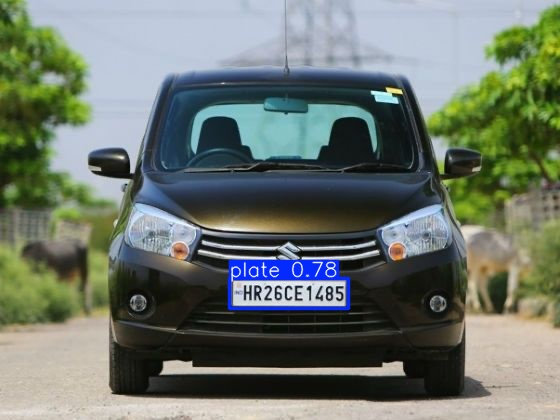

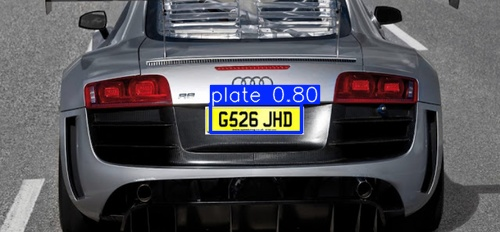

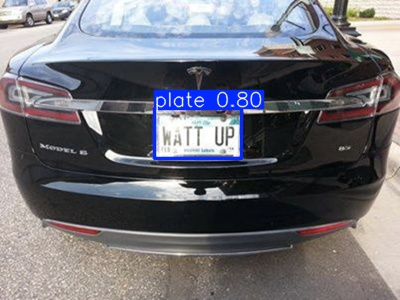

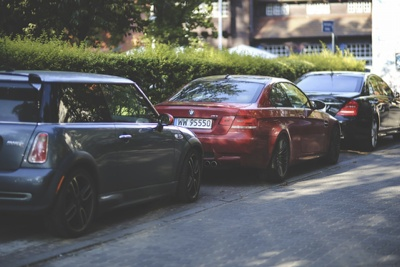

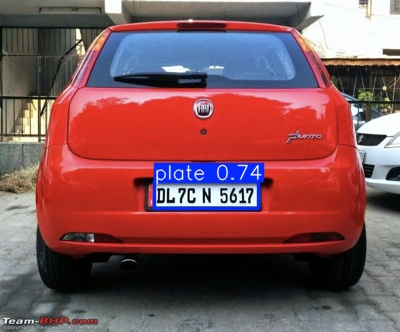

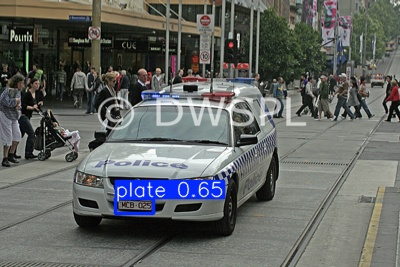

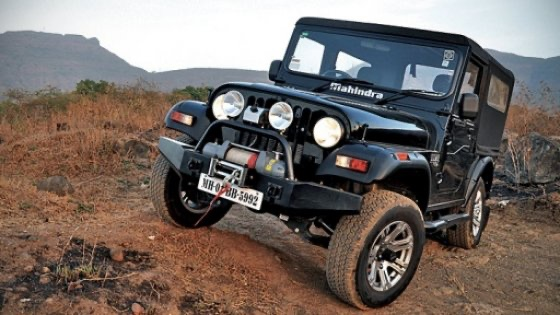

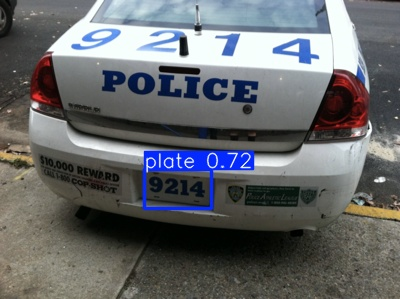

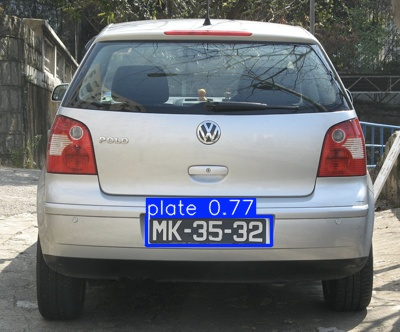

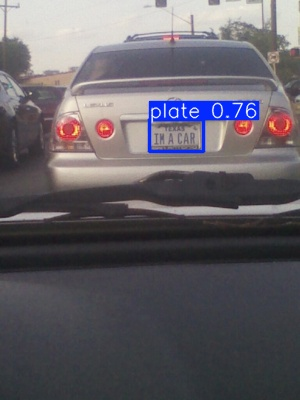

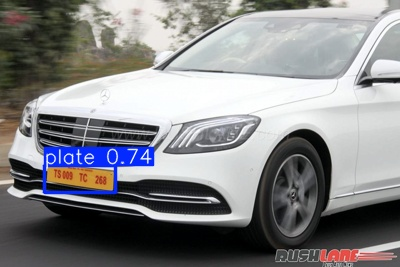

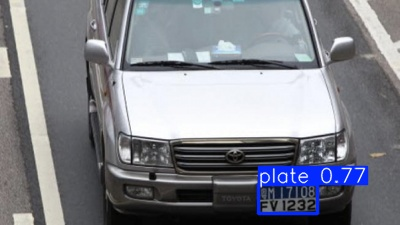

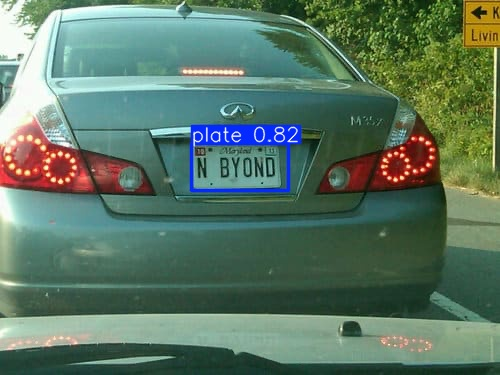

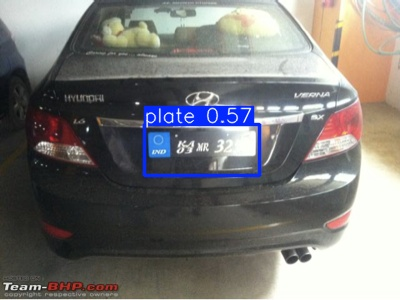

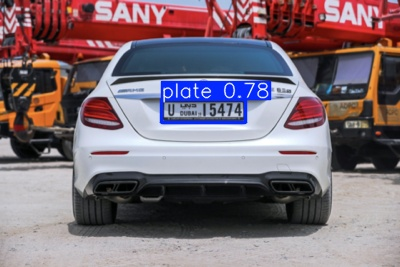

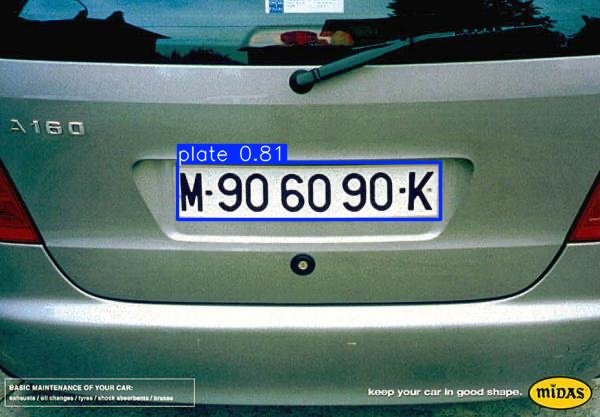

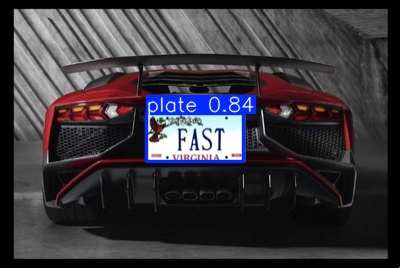

In [ ]:
import os
from IPython.display import Image, display

# Path to the folder containing predicted images
predict_folder = '/content/runs/detect/predict'

# Loop through each image file in the predictions folder
for img_name in os.listdir(predict_folder):
    img_path = os.path.join(predict_folder, img_name)

    # Display the image in the notebook
    display(Image(filename=img_path))


In [ ]:
# Install the EasyOCR library for Optical Character Recognition (OCR)
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 32.7 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import pandas as pd
import easyocr

# Initialize the EasyOCR reader (English language)
reader = easyocr.Reader(['en'])

# Paths
predict_folder = '/content/runs/detect/predict'  # Folder containing YOLO predicted images
cropped_folder = '/content/cropped_plates'       # Folder to save cropped license plates
os.makedirs(cropped_folder, exist_ok=True)

csv_output_path = '/content/plate_ocr_results.csv'  # Path to save OCR results as CSV

ocr_results_list = []  # List to store OCR results

# Loop through prediction results
for result in results:
    img_path = result.path
    img = cv2.imread(img_path)

    # Loop through all detected bounding boxes
    for i, box in enumerate(result.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)  # Get bounding box coordinates

        # Crop the detected plate area from the image
        plate_crop = img[y1:y2, x1:x2]

        # Save the cropped plate image
        cropped_path = os.path.join(cropped_folder, f'{os.path.basename(img_path).split(".")[0]}_plate_{i}.jpg')
        cv2.imwrite(cropped_path, plate_crop)

        # Perform OCR on the cropped plate
        ocr_result = reader.readtext(plate_crop)

        if ocr_result:
            text = ocr_result[0][1]            # Extract recognized text
            confidence = ocr_result[0][2]       # Extract OCR confidence
        else:
            text = ''
            confidence = 0.0

        # Append the OCR results
        ocr_results_list.append({
            'image_name': os.path.basename(img_path),
            'plate_number': text,
            'confidence': confidence
        })

# Save OCR results to a CSV file
df = pd.DataFrame(ocr_results_list)
df.to_csv(csv_output_path, index=False)

print(f"OCR results saved to {csv_output_path}")


Progress: |██████████████████████████████████████████████████| 100.0% Complete OCR results saved to /content/plate_ocr_results.csv


In [ ]:
import pandas as pd

# Load the OCR results from the saved CSV file
df = pd.read_csv('/content/plate_ocr_results.csv')


In [ ]:
# Display the first 20 rows of the OCR results DataFrame
df.head(20)


image_name   plate_number  confidence
0     Cars0.png     KLG1CA2555    0.746854
1    Cars10.png       TN 37 Cs    0.693187
2   Cars101.png  HR 26 BC 5514    0.885179
3   Cars116.png       MK-35-32    0.584379
4   Cars123.png  HR 26 BC 5514    0.927842
5   Cars136.png         5i5474    0.155283
6   Cars137.png            NaN    0.000000
7   Cars152.png      DL49 AK49    0.627173
8   Cars159.png    DLZC N 5617    0.707783
9    Cars16.png            NaN    0.000000
10  Cars166.png         IMCAR,    0.146169
11  Cars170.png            NaN    0.000000
12  Cars173.png        VIRGINL    0.461533
13  Cars187.png        ALR 486    0.999694
14  Cars198.png     Mho1av8866    0.611205
15  Cars204.png         BYOND|    0.330703
16  Cars208.png            V-8    0.510378
17  Cars216.png       OPEC Loi    0.924810
18  Cars222.png      (26-SPF-4    0.464483
19  Cars227.png            NaN    0.000000